In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
print("imported")

imported


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32
EPOCHS = 10 
FOLDS = 3   
DATA_DIR = '../../../chest_xray/train'

print("hypermarameters loaded...")

hypermarameters loaded...


In [8]:
def load_data(data_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_data = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )
    
    val_data = datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )
    
    return train_data, val_data

train_data, val_data = load_data(DATA_DIR)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [10]:
# Étape 2: Création du modèle
def create_model(num_conv_layers):
    model = models.Sequential()

    print("Création de la couche d'entrée...")
    model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    print(f"Ajout de {num_conv_layers} couches de convolution...")
    for i in range(num_conv_layers):
        print(f"Ajout de la couche de convolution {i+1}...")
        model.add(layers.Conv2D(16, (3, 3), activation='relu')) 
        model.add(layers.MaxPooling2D((2, 2)))

    print("Ajout de la couche Flatten...")
    model.add(layers.Flatten())

    print("Ajout de la couche Dense avec 128 unités...")
    model.add(layers.Dense(64, activation='relu'))

    print("Ajout de la couche de sortie avec activation sigmoid...")
    model.add(layers.Dense(1, activation='sigmoid'))

    print("Compilation du modèle...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("Modèle créé avec succès.")
    return model

In [12]:
# Étape 3: Validation croisée K-Fold
def k_fold_cross_validation(num_conv_layers, train_data, val_data):
    kf = KFold(n_splits=FOLDS, shuffle=True)
    accuracy_list = []
    auc_list = []
    all_histories = []  # Pour stocker les historiques d'entraînement

    # Boucle à travers les différents plis
    for train_index, val_index in kf.split(train_data):
        # Créer un modèle
        model = create_model(num_conv_layers)
        
        # Entraînement avec EarlyStopping pour éviter le sur-apprentissage
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stopping], verbose=0)

        # Stocker l'historique
        all_histories.append(history.history)

        # Évaluation
        val_loss, val_accuracy = model.evaluate(val_data)
        accuracy_list.append(val_accuracy)

        # Calcul de la courbe ROC
        y_true = val_data.classes
        y_scores = model.predict(val_data).ravel()
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

    return np.mean(accuracy_list), np.mean(auc_list), all_histories

In [14]:
# Étape 4: Test avec différents nombres de couches de convolution
conv_layers_list = [2, 3]  # Reduced number of layers to test
results = {}

for num_layers in conv_layers_list:
    accuracy, roc_auc, histories = k_fold_cross_validation(num_layers, train_data, val_data)
    results[num_layers] = {'Accuracy': accuracy, 'AUC': roc_auc}
    print(f'Layers: {num_layers}, Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}')

# Fonction pour afficher les résultats (graphes déplacés ici)
def plot_results(histories, conv_layers_list):
    for num_layers, history in zip(conv_layers_list, histories):
        # Affichage des courbes de précision
        plt.plot(history['accuracy'], label='Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy for {num_layers} Convolutional Layers')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid()
        plt.show()

        # Affichage des courbes de perte
        plt.plot(history['loss'], label='Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'Model Loss for {num_layers} Convolutional Layers')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')
        plt.grid()
        plt.show()

Création de la couche d'entrée...
Ajout de 2 couches de convolution...
Ajout de la couche de convolution 1...
Ajout de la couche de convolution 2...
Ajout de la couche Flatten...
Ajout de la couche Dense avec 128 unités...
Ajout de la couche de sortie avec activation sigmoid...
Compilation du modèle...
Modèle créé avec succès.


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 879ms/step - accuracy: 0.9699 - loss: 0.0814
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 853ms/step
Création de la couche d'entrée...
Ajout de 2 couches de convolution...
Ajout de la couche de convolution 1...
Ajout de la couche de convolution 2...
Ajout de la couche Flatten...
Ajout de la couche Dense avec 128 unités...
Ajout de la couche de sortie avec activation sigmoid...
Compilation du modèle...
Modèle créé avec succès.
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 836ms/step - accuracy: 0.9512 - loss: 0.1246
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step
Création de la couche d'entrée...
Ajout de 2 couches de convolution...
Ajout de la couche de convolution 1...
Ajout de la couche de convolution 2...
Ajout de la couche Flatten...
Ajout de la couche Dense avec 128 unités...
Ajout de la couche de sortie avec activation sigmoid...
Compilation du modèle...
Modèle créé avec succès.
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step - accuracy: 0.9341 - loss: 0.2183
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s

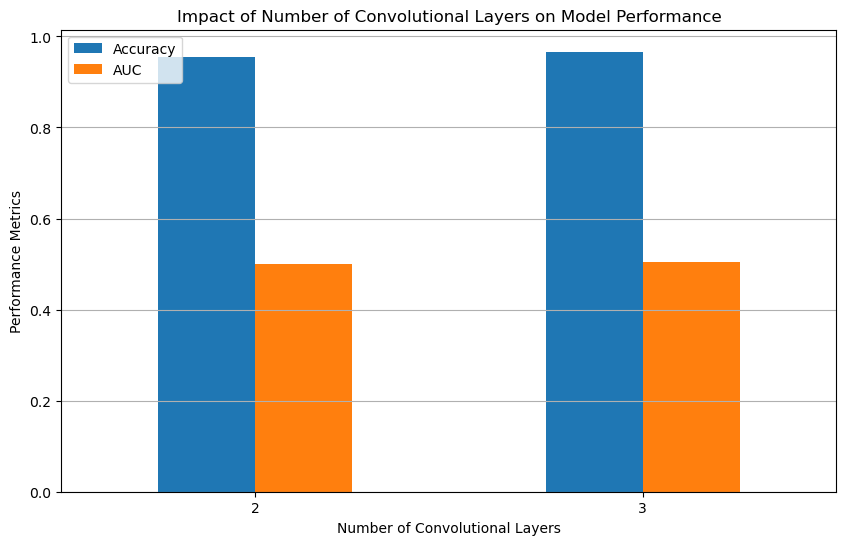

In [16]:
def conv_layer_nb_impact():
    results_df = pd.DataFrame(results).T
    results_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Impact of Number of Convolutional Layers on Model Performance')
    plt.xlabel('Number of Convolutional Layers')
    plt.ylabel('Performance Metrics')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.show()

conv_layer_nb_impact()


--- Résultats Finaux ---
   Accuracy       AUC
2  0.955577  0.500560
3  0.966443  0.504351

--- Détails pour 2 Couches de Convolution ---
  Précision Moyenne: 0.9556
  AUC Moyenne: 0.5006

--- Détails pour 3 Couches de Convolution ---
  Précision Moyenne: 0.9664
  AUC Moyenne: 0.5044


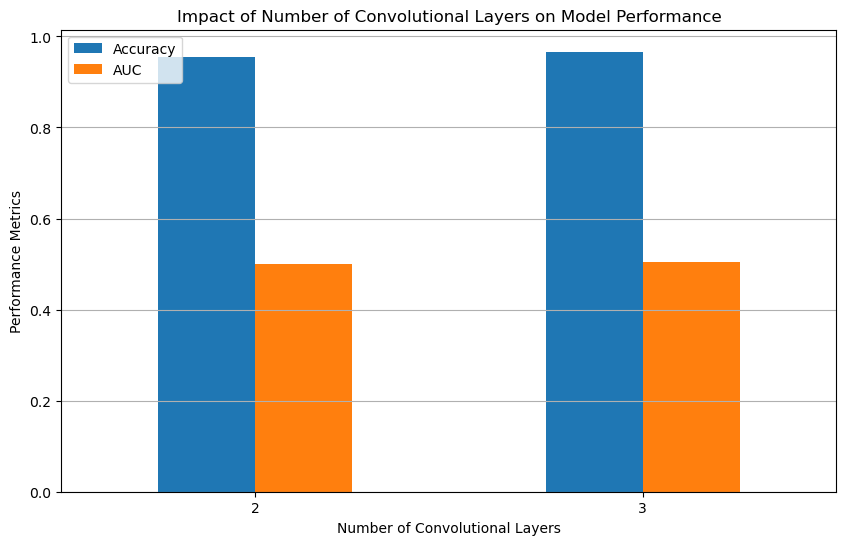

KeyError: 'accuracy'

In [19]:
# Fonction pour afficher les résultats en texte
def display_results(results):
    results_df = pd.DataFrame(results).T
    print("\n--- Résultats Finaux ---")
    print(results_df)

    # Détails supplémentaires pour chaque nombre de couches
    for num_layers, metrics in results.items():
        print(f"\n--- Détails pour {num_layers} Couches de Convolution ---")
        print(f"  Précision Moyenne: {metrics['Accuracy']:.4f}")
        print(f"  AUC Moyenne: {metrics['AUC']:.4f}")

# Appel des fonctions pour visualiser les résultats
display_results(results)
conv_layer_nb_impact()
plot_results([history for _, history in results.items()], conv_layers_list)